## Концептуальное описание сервиса

Рассмотрим следующую задачу: у нас есть портфель размером X д.ед. и набор моделей временного ряда $\{Y_{t}^{i}\}$. На каждом шаге $t$ каждая из моделей строит нам прогноз на $k$ шагов вперёд. Мы хотим распределить капитал между стратегиями в такой пропорции, чтобы сумма приростов $ln(\Delta X_t)$, где $\Delta X_t = X_t^{close} - X_{t-1}^{close}$  была максимальной.

### Функциональные требования:
<hr>


Сервис должен уметь:

**Концепт:**
1) Принимать на вход массив данных о ценах, иных характеристиках финансового ряда
2) Передавать массив на вход моделям предсказания временных рядов
3) На основе полученных прогнозов сравнивать модели между собой

**MVP**
1) Принимать на вход массив данных о ценах, иных характеристиках финансового ряда
2) Передавать массив на вход моделям предсказания временных рядов
3) Принимать решение об аллокации капитала на шаге $t$ между моделями с учётом полученного прогноза на основе правил с ограничениями на концетрацию риска: а) в одном активе б) в одной модели в)транзакционных издержек так, чтобы сумма на заданном горизонте инвестирования (k-периодов вперёд) была оптимальной
4) Подстраивать данное решение на каждом первом/j-ом шаге

**Production (минимальный вариант)**
1) Отправлять на e-mail/Telegram сообщение с данными об а) оптимальной аллокации б)

**Production (желаемый идеальный вариант)**
0) Все вышеперечисленное
1) На основе полученных оптимальных значений отправлять по API заявки брокеру на изменение состава-портфеля
2) Снимать существующие заявки, если таковые были. Проверять, соответствуют ли текущие заявки желаемой аллокации
3) Ставить заявки типа "стоп-лимит" соотвественно прогнозным значениям
4) Иметь kill-switch, автоматически закрывающий все позиции и останавливающий сервис
5) Иметь возможность в ручном режиме отключать модели

### Нефункциональные требования:
<hr>

1) Сервис должен логировать и отправлять сообщения об ошибках
2) Сервис должен иметь downtime не более
3) Сервис должен работать на базе облачной инфраструктуры - вычисления, хранение данных и отправка сообщений не должны проводиться на локальной машине.
4) Данные должны дублироваться в и/или локальную копию на физическом носителе, другое облачное хранилище
5) Сервис должен иметь возможность добавления новых моделей в стандартизированном формате

## Proof-of-Concept 

### По мотивам ВКР
<hr>

Текст работы доступен по ссылке https://economics.hse.ru/depe/diplomas/page7.html/832192018

#### Необходимые импорты

In [1]:
import numpy as np
import pandas as pd
import sympy as sm 
import matplotlib.pyplot as plt
import math

In [2]:
from statsmodels.tsa.stattools import acovf
from scipy.linalg import toeplitz

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tabulate import tabulate

In [4]:
import time
from sympy import solve_rational_inequalities, Poly, I, re, im, sqrt, solve
from sympy.solvers.inequalities import reduce_rational_inequalities
from functools import reduce

In [5]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [6]:
from tqdm.auto import tqdm

#### Препоценнсинг данных

In [7]:
df_60 = pd.read_csv('Data/MOEX_IMOEX, 60 (3).csv', index_col = 'time')
df_240 = pd.read_csv('Data/MOEX_IMOEX, 240.csv', index_col = 'time')
df_1440 = pd.read_csv('Data/MOEX_IMOEX, 1D (2).csv', index_col = 'time')


#### Нечёткие модели предсказания временных рядов с чётким прогнозом

### Fuzzy AR

In [8]:

def fuzzy_wn(n,mu,sigma,A):
    w_n = np.random.normal(mu,sigma,n)
    w_n_tilde = [(c-A,c,c+A) for c in w_n]
    return w_n_tilde
def fuzzy_ar1(w_n, a_1):
    ar_tilde = []
    ar_tilde.append(w_n[0])
    for i,j in enumerate(w_n[1:]):
        value = np.add(np.dot([*ar_tilde[i]],a_1),[*j])
        ar_tilde.append(tuple(value))
    return ar_tilde
        
def fuzzy_wn_am(n,mu,sigma,A):
    w_n = np.random.normal(mu,sigma,n)
    w_n_tilde = [(c-A,c,c+A) for c in w_n]
    return w_n_tilde
def fuzzy_ar1_am(w_n, a_1):
    ar_tilde = []
    ar_tilde.append(w_n[0])
    for i,j in enumerate(w_n[1:]):
        value = np.add(np.dot([*ar_tilde[i]],a_1),[*j])
        ar_tilde.append(tuple(value))
    return ar_tilde
def fuzzy_a1_yung(x_n):
    x_l = [i[0] for i in x_n]
    x_m = [i[1] for i in x_n]
    x_r = [i[2] for i in x_n]
    
    num_1 = np.sum(1/3*np.add(np.multiply(x_l[1:],x_l[:-1]), np.multiply(x_r[1:],x_r[:-1])))
    num_2 = np.sum(1/6*np.multiply(x_m[:-1],np.add(x_l[1:],x_r[1:])))
    num_3 = np.sum(1/6*np.multiply(x_m[1:],np.add(x_l[:-1],x_r[:-1])))
    num_4 = np.sum(2/3*np.multiply(x_m[1:],x_m[:-1]))
    
    numerator = num_1 + num_2 + num_3 + num_4
    
    den_1 = 1/3*np.sum(np.multiply(x_l[:-1],x_l[:-1]))
    den_2 = 2/3*np.sum(np.multiply(x_m[:-1],x_m[:-1]))
    den_3 = 1/3*np.sum(np.multiply(x_r[:-1],x_r[:-1]))
    den_4 = 1/3*np.sum(np.multiply(x_m[:-1], np.add(x_l[:-1], x_r[:-1])))
    
    denominator = den_1 + den_2 + den_3 + den_4
    
    return numerator/denominator
    
def fuzzy_a1_yung_forecast(x_n, ind_start, ind_stop, a_1_hat):
    test_0 = x_n[ind_start]
    actual_values = x_n[ind_start:ind_stop]
    
    test_yung = []
    test_naive = []
    
    test_yung.append(test_0)
    test_naive.append(test_0)
    
    for i in actual_values:
        value = np.dot([*i], a_1_hat)
        test_yung.append(tuple(value))
        test_naive.append(i)
        
    return test_yung, test_naive
                       
    
    
def fuzzy_error_ind(x_n, x_n_hat):
    err_list_ind = []
    eta = sm.symbols('\eta')
    for i,j in zip(x_n, x_n_hat):
        tilde_slope = np.abs(i[1]-i[0])
        hat_slope = np.abs(j[1]-j[0])
        
        
        tilde_func_l = i[0]+eta*tilde_slope
        hat_func_l = j[0]+eta*hat_slope
        
        tilde_func_r = i[2]-eta*tilde_slope
        hat_func_r = j[2]-eta*hat_slope
        
        l_int = sm.integrate((tilde_func_l-hat_func_l)**2, (eta,0,1))
        r_int = sm.integrate((tilde_func_r-hat_func_r)**2, (eta,0,1))
        
        err_list_ind.append(math.sqrt(l_int+r_int))
    
    return err_list_ind
        
        
        
        
def fuzzy_error_full(ind_error):
    n = len(ind_error)
    full_error = np.sum(np.matmul(ind_error, ind_error))/n
    full_error = np.sqrt(full_error)
    return np.sqrt(full_error)
    
def fuzzy_ar_N(w_n, a_list, N):
    ar_tilde = []
    
    for i in range(0,N):
        ar_tilde.append(w_n[i])
        
    for i,j in enumerate(w_n[N:]):
        value = ar_tilde[-N:]
        mul = [np.dot(value[-k-1], a_list[k]) for k in range(0, N)]
        
        add = reduce(np.add, mul)
        add = tuple(np.add(add, j))
        
        ar_tilde.append(add)
    return ar_tilde
        
        
    
    
#Версия 1.0, без кваризарндома, работает в пределах ограничения по времени до порядка p = 4 включительно

def gen_a_stat(N, quasirandom = False, time_constraint = 15):
    
    stationarity = False
    m, p = sm.symbols('m p')
    
    start_time = time.time()
    while stationarity == False:
        
        a_list = np.random.uniform(-1,1, N)
        
        eq = [m**p for p in [*range(0,N+1)][::-1]]
        eq[1:] = [i*j for i,j in zip(eq[1:],a_list)]
        eq = [str(i) for i in eq]
        
        eq = '-'.join(eq)
        
        solutions = solve(eq, m)
        
        roots = [sqrt(re(i)**2 + im(i)**2) for i in solutions]
        roots_bool = [True if i < 1 else False for i in roots]
        
        if all(roots_bool) == True:
            stationarity = True
        elif (all(roots_bool) == False) and (quasirandom == True):
            running_time = time.time()
            if (running_time - start_time) > time_constraint:
                raise Exception('Running too long')
            pass
                
                
        elif (all(roots_bool) == False) and (quasirandom == False):
            running_time = time.time()
            if (running_time - start_time) > time_constraint:
                raise Exception('Running too long')
            pass
        
    return a_list
    
def fuzzy_ar_p_estimation(series, order):
    
    sign_list = list(set([*combinations([1,-1]*order, order)]))
    sign_list = [list(i) for i in sign_list]
    
    x_l = [i[0] for i in series]
    x_m = [i[1] for i in series]
    x_r = [i[2] for i in series]
    
    
    den_dict = {}
    
    num_1_dict = {}
    
    num_2_dict = {}
    
    for i in range(1,order+1):
    
        den_1 = np.sum(1/3*(np.multiply(x_l[order-i:-i],x_l[order-i:-i])))
        den_2 = np.sum(2/3*(np.multiply(x_m[order-i:-i],x_m[order-i:-i])))
        den_3 = np.sum(1/3*np.multiply(x_r[order-i:-i],x_r[order-i:-i]))
        den_4 = np.sum(1/3*(np.multiply(x_m[order-i:-i], np.add(x_l[order-i:-i], x_r[order-i:-i]))))
    
        denominator = den_1 + den_2 + den_3 + den_4
        
        den_dict[i] = denominator
        
        
        num_1 = np.sum(2/3*(np.multiply(x_m[order:],x_m[order-i:-i])))
        num_2 = np.sum(1/6*(np.multiply(x_m[order:], np.add(x_l[order-i:-i], x_r[order-i:-i]))))
        num_3 = np.sum(1/6*(np.multiply(x_m[order-i:-i], np.add(x_l[order:], x_r[order:]))))
                     
        num_4_plus = np.sum(1/3*(np.add(np.multiply(x_l[order:],x_l[order-i:-i]),np.multiply(x_r[order:],x_r[order-i:-i]))))
        num_4_minus = np.sum(1/3*(np.add(np.multiply(x_l[order:],x_r[order-i:-i]),np.multiply(x_r[order:],x_l[order-i:-i]))))
        
        num_plus = num_1 + num_2 + num_3 + num_4_plus
        num_minus = num_1 + num_2 + num_3 + num_4_minus  
        
        num_1_dict[i] = num_plus
        num_1_dict[-i] = num_minus
    
        
        num_1 = np.sum(2/3*(np.multiply(x_m[order-1:-1],x_m[order-i:-i])))
        num_2 = np.sum(1/6*(np.multiply(x_m[order-1:-1], np.add(x_l[order-i:-i], x_r[order-i:-i]))))
        num_3 = np.sum(1/6*(np.multiply(x_m[order-i:-i], np.add(x_l[order-1:-1], x_r[order-1:-1]))))
                     
        num_4_plus = np.sum(1/3*(np.add(np.multiply(x_l[order-1:-1],x_l[order-i:-i]),np.multiply(x_r[order-1:-1],x_r[order-i:-i]))))
        num_4_minus = np.sum(1/3*(np.add(np.multiply(x_l[order-1:-1],x_r[order-i:-i]),np.multiply(x_r[order-1:-1],x_l[order-i:-i]))))
        
        num_plus = num_1 + num_2 + num_3 + num_4_plus
        num_minus = num_1 + num_2 + num_3 + num_4_minus  
        
        num_2_dict[i] = num_plus
        num_2_dict[-i] = num_minus
        
    
    var_dict = {}
        
    for i in range(1,order+1):
        var_str = 'a_{'+ f'{i}' +'}'

        var_dict[i] = sm.Symbol(var_str)
    
    var_vals = list(var_dict.values())
    
    solutions_list = []
    sign_sol_list = []
    systems_list = []
        
    for signs in sign_list:
        eq_list = []
            
        for index,sign in enumerate(signs):
            eq_ = sign*num_1_dict[sign*(index+1)]
            
            for p in range(1,order+1):
                if p != index + 1:
                    
                    eq_ -= sign*signs[p-1]*var_dict[p]*num_2_dict[sign*signs[p-1]*p]
            
            eq_ = eq_/den_dict[index+1] - var_dict[index+1]

            eq_list.append(eq_)
        systems_list.append(eq_list)
        solution = sm.solve(eq_list, var_vals, set=False)
        solutions_list.append(solution)
        if solution != []:
            sol_signs = [np.sign(i) for i in list(solution.values())]
            if all(sol_signs[i] == signs[i] for i in range(0, len(signs))) == True:
                sign_sol_list.append(solution)
    #Проверка на стационарность полученных решений
    
    stat_solutions = []
    
    m, p = sm.symbols('m p')
    
    
    for i in solutions_list:
        a_list = list(i.values())
        
        eq = [m**p for p in [*range(0,order+1)][::-1]]
        eq[1:] = [i*j for i,j in zip(eq[1:],a_list)]
        eq = [str(i) for i in eq]
        
        eq = '-'.join(eq)
        
        solution = solve(eq, m)
        
        roots = [sm.sqrt(sm.re(i)**2 + sm.im(i)**2) for i in solution]
        roots_bool = [True if i < 1 else False for i in roots]
        
        if all(roots_bool) == True:
            stat_solutions.append(i)
        
        dicts = [den_dict,num_1_dict, num_2_dict]
        
    minimum_solution = []
    
    for i in solutions_list:
        soc_sol = soc_ar_p(dicts, list(i.values()))
        if is_definite_eigenval(soc_sol) == 'Problem is positively definite':
            minimum_solution.append(i)
    
    min_stat_solution = []
    
    for i in stat_solutions:
        soc_sol = soc_ar_p(dicts, list(i.values()))
        if is_definite_eigenval(soc_sol) == 'Problem is positively definite':
            min_stat_solution.append(i)
        
        
            
        
                
            
             
    return solutions_list, stat_solutions, sign_sol_list, minimum_solution, min_stat_solution, systems_list, dicts
    
    
    
    
def fuzzy_ar_p_estimation_fast(series, order):
    
    sign_list = list(set([*combinations([1,-1]*order, order)]))
    sign_list = [list(i) for i in sign_list]
    
    x_l = [i[0] for i in series]
    x_m = [i[1] for i in series]
    x_r = [i[2] for i in series]
    
    
    den_dict = {}
    
    num_1_dict = {}
    
    num_2_dict = {}
    
    for i in range(1,order+1):
    
        den_1 = np.sum(1/3*(np.multiply(x_l[order-i:-i],x_l[order-i:-i])))
        den_2 = np.sum(2/3*(np.multiply(x_m[order-i:-i],x_m[order-i:-i])))
        den_3 = np.sum(1/3*np.multiply(x_r[order-i:-i],x_r[order-i:-i]))
        den_4 = np.sum(1/3*(np.multiply(x_m[order-i:-i], np.add(x_l[order-i:-i], x_r[order-i:-i]))))
    
        denominator = den_1 + den_2 + den_3 + den_4
        
        den_dict[i] = denominator
        
        
        num_1 = np.sum(2/3*(np.multiply(x_m[order:],x_m[order-i:-i])))
        num_2 = np.sum(1/6*(np.multiply(x_m[order:], np.add(x_l[order-i:-i], x_r[order-i:-i]))))
        num_3 = np.sum(1/6*(np.multiply(x_m[order-i:-i], np.add(x_l[order:], x_r[order:]))))
                     
        num_4_plus = np.sum(1/3*(np.add(np.multiply(x_l[order:],x_l[order-i:-i]),np.multiply(x_r[order:],x_r[order-i:-i]))))
        num_4_minus = np.sum(1/3*(np.add(np.multiply(x_l[order:],x_r[order-i:-i]),np.multiply(x_r[order:],x_l[order-i:-i]))))
        
        num_plus = num_1 + num_2 + num_3 + num_4_plus
        num_minus = num_1 + num_2 + num_3 + num_4_minus  
        
        num_1_dict[i] = num_plus
        num_1_dict[-i] = num_minus
    
        
        num_1 = np.sum(2/3*(np.multiply(x_m[order-1:-1],x_m[order-i:-i])))
        num_2 = np.sum(1/6*(np.multiply(x_m[order-1:-1], np.add(x_l[order-i:-i], x_r[order-i:-i]))))
        num_3 = np.sum(1/6*(np.multiply(x_m[order-i:-i], np.add(x_l[order-1:-1], x_r[order-1:-1]))))
                     
        num_4_plus = np.sum(1/3*(np.add(np.multiply(x_l[order-1:-1],x_l[order-i:-i]),np.multiply(x_r[order-1:-1],x_r[order-i:-i]))))
        num_4_minus = np.sum(1/3*(np.add(np.multiply(x_l[order-1:-1],x_r[order-i:-i]),np.multiply(x_r[order-1:-1],x_l[order-i:-i]))))
        
        num_plus = num_1 + num_2 + num_3 + num_4_plus
        num_minus = num_1 + num_2 + num_3 + num_4_minus  
        
        num_2_dict[i] = num_plus
        num_2_dict[-i] = num_minus
        
    
    var_dict = {}
        
    for i in range(1,order+1):
        var_str = 'a_{'+ f'{i}' +'}'

        var_dict[i] = sm.Symbol(var_str)
    
    var_vals = list(var_dict.values())
    
    sign_sol_list = []
    

    for signs in sign_list:
        if len(sign_sol_list) == 0:
            eq_list = []

            for index,sign in enumerate(signs):
                eq_ = sign*num_1_dict[sign*(index+1)]

                for p in range(1,order+1):
                    if p != index + 1:

                        eq_ -= sign*signs[p-1]*var_dict[p]*num_2_dict[sign*signs[p-1]*p]

                eq_ = eq_/den_dict[index+1] - var_dict[index+1]

                eq_list.append(eq_)
            solution = sm.solve(eq_list, var_vals, set=False)

            if solution != []:
                sol_signs = [np.sign(i) for i in list(solution.values())]
                if all(sol_signs[i] == signs[i] for i in range(0, len(signs))) == True:
                    sign_sol_list.append(solution)
        elif len(sign_sol_list) != 0:
            break
    return sign_sol_list

### FTS-модели 

In [9]:

def discource(x, scale = 0.15):
    
    std_data = np.std(x)
    max_data = np.max(x)
    min_data = np.min(x)
    
    u_1 = min_data - scale * std_data
    u_2 = max_data + scale * std_data

    len_interval = std_data / 20
    len_discource = int(abs(u_1 - u_2) // len_interval)
    
    interval_list = []
    
    u_start = u_1
    
    for i in range(0, len_discource):
        u_finish = u_start + len_interval
        interval_list.append((u_start, u_finish))
        u_start += len_interval
    
    
    return interval_list, (u_1, u_2), len_interval
    
def discource(x, scale = 0.15):
    
    std_data = np.std(x)
    max_data = np.max(x)
    min_data = np.min(x)
    
    u_1 = min_data - scale * std_data
    u_2 = max_data + scale * std_data

    len_interval = std_data / 20
    len_discource = int(abs(u_1 - u_2) // len_interval)
    
    interval_list = []
    
    u_start = u_1
    
    for i in range(0, len_discource):
        u_finish = u_start + len_interval
        interval_list.append((u_start, u_finish))
        u_start += len_interval
    
    
    return interval_list, (u_1, u_2), len_interval
    
# x = np.random.normal(0,1,100)
# x_train, x_test = x[0:70], x[70:]
# intervals, u, step = discource(x_train)

def fuzzyfy_fts(u, step, a_scale = 2):
    u_start = u[0]
    A = step * a_scale
    vertice_list = []
 
    while u_start < u[1]:
        vertice_list.append((u_start-A,u_start,u_start + A))
        u_start += step
        
    return vertice_list

 
# fuzzy_sets = fuzzyfy_fts(u, step)
# cut = 10
# plt.figure(figsize = (12,8))

# cut_int = [j for i in intervals[:cut+1] for j in i]

# counter = 0
# for i,k in enumerate(cut_int[:-1]):
#     if i % 2 == 1:
#         print(k, cut_int[:-1][i+1], ((k + cut_int[:-1][i+1])/2))
#         plt.text(x = ((k + cut_int[:-1][i+1]) / 2), y = 0.05 , s = f'u_{i-counter}')
#     else:
#         counter += 1
#         pass
# plt.xticks(cut_int)
# for i in cut_int:
#     plt.axvline(i, linestyle = '--', color = 'black', alpha = 0.1)
# plt.xlabel('Значения переменной')
# plt.ylabel('Функция принадлежности нечетких множеств $A_i$')
# colors = cm.get_cmap('turbo_r', cut+2)
# for k,i in enumerate(fuzzy_sets[:cut+2]):
#     plt.plot([i[0],i[1]],[0,1], color = colors(k))
#     plt.plot([i[1],i[2]],[1,0], color = colors(k))
    
# plt.show()


def determine_membership(x, fuzzy_sets):
    ling_var_dict = {i : [] for i in x}
    
    length_fuzzy = len(fuzzy_sets)
    
    for i in x:
        for k,j in enumerate(fuzzy_sets):
            if i <= j[0]:
                counter = 0
                while counter < (length_fuzzy-k-1):
                    ling_var_dict[i].append([0])
                    counter += 1
                break
            if i >= j[2]:
                ling_var_dict[i].append([0])
                pass 
            if j[0] <= i <= j[1]:
                ling_var_dict[i].append([(1/(j[1]-j[0]))*(i-j[0])])
            elif j[1] < i <= j[2]:
                ling_var_dict[i].append([(1/(j[2]-j[1]))*(j[2]-i)])
                
    for i in ling_var_dict.keys():
        
        ling_var_dict[i] = [j for k in ling_var_dict[i] for j in k]
        
    return ling_var_dict

# ling_var_prelim = determine_membership(x_train, fuzzy_sets)
def fuzzyfy_data_fts(rel_dict : dict):
    new_rel_dict = {}
    
    for i in rel_dict.keys():
        
        datum = rel_dict[i]
        
        max_datum = max(datum)
        
        index = datum.index(max_datum)
        
        new_rel_dict[i] = index
        
    return new_rel_dict, len(datum)+1
    
        
        
        
    
# fuzzyfied_data, len_datum = fuzzyfy_data_fts(ling_var_prelim)

def count_relations(fuz_data : dict, len_datum : int):
    
    relations_matrix = np.zeros(shape = (len_datum, len_datum))
    iter_list = list(fuz_data.keys())
    str_representation = []
    
    for i,k in enumerate(list(fuz_data.keys())[:-1]):
        cause = fuz_data[k]
        
        effect = fuz_data[iter_list[i+1]]
    
        
        relations_matrix[cause, effect] += 1
        
        str_representation.append(f'A_{cause+1} implies A_{effect+1}')
    chrono_cause = str_representation
    
    return relations_matrix, sorted(set(str_representation)), chrono_cause
        
              

def count_jump(fuz_data : dict, len_datum : int):
    
    num_sets = len_datum
    jump_vector = np.zeros((num_sets*2+1, 1))
    iter_list = list(fuz_data.keys())
    
    for i,k in enumerate(list(fuz_data.keys())[:-1]):
        
        t_0 = i + 1
        
        cause = fuz_data[k]
        effect = fuz_data[iter_list[i+1]]
        jump = effect - cause
    
        
        jump_vector[jump+num_sets] += t_0
        
    jump_vector = np.dot(jump_vector, 1/np.sum(jump_vector))
    
    return jump_vector
                  
    
def count_t_weights(fuz_data : dict, len_datum : int):
    
    
    relations_matrix = np.zeros(shape = (len_datum, len_datum))
    iter_list = list(fuz_data.keys())
    
    for i,k in enumerate(list(fuz_data.keys())[:-1]):
        
        t_0 = i + 1
        
        cause = fuz_data[k]
        effect = fuz_data[iter_list[i+1]]
    
        
        relations_matrix[cause, effect] += t_0
        
    for k,i in enumerate(relations_matrix):
        sum_ = np.sum(i)
        if sum_ != 0:
            relations_matrix[k] = np.dot(i, (1/sum_))
    
    return relations_matrix 
    
    
    
def forecast_rubio_fts(cur_val, fuzzy_sets, weight_matrix, jump_vec, gamma = 0.9):
    
    # assume cur_val = 35
    ind = cur_val
#     jump_vec = [i for i in list(jump_vec)]
    cur_set = fuzzy_sets[ind]
    
    w = weight_matrix[ind]
    
    forecast = np.array([0,0,0])
    
    for i,k in enumerate(w):
        
        forecast = np.add(forecast, np.dot(fuzzy_sets[i],k))
    print(forecast)  
    if np.sum(forecast) == 0:
        forecast = np.array(cur_set)
    forecast = forecast * (1-gamma)
    
    m = len(fuzzy_sets)
    left_ = max([-len(fuzzy_sets), 1 - ind])
    right_ = min(len(fuzzy_sets)-1, len(fuzzy_sets)-ind)
    rel_jump = jump_vec[m + left_ : m + right_]
    
    for i,k in enumerate(rel_jump):
#         if left_
        f_set = np.dot(np.array(fuzzy_sets[ind+left_]),float(k))*(gamma)
        
        forecast = np.add(forecast, f_set)
        
        left_ += 1
        
    
    
    
    
    

    
    return forecast


# plt.figure(figsize = (12,8))
# 
# 
# counter = 70
# plt.plot(x_train[:counter], color = 'blue')
# plt.plot([i for i in range(counter, 101)], [x_train[-1]]+list(x_test),color = 'blue', linestyle = '--')
# plt.grid()
# naive = [fuzzyfied_data[x_train[-1]]]
# naive = naive + [i for i in x_test_fuzzy.values()]
# for i in x_test_fuzzy:
    
#     ind = x_test_fuzzy[i]
    
#     fcst = forecast_rubio_fts(ind, fuzzy_sets,weight_matrix, s_jump)
    
    
# #     plt.scatter(counter, i, color = 'black')
    
#     plt.plot([counter,counter+1],[fcst[1],fcst[0]], color = 'red')
#     plt.plot([counter,counter+1],[fcst[1],fcst[2]], color = 'red')
    
#     fact = fuzzy_sets[ind]
    
#     plt.plot([counter,counter+1],[fact[1],fact[0]], color = 'blue')
#     plt.plot([counter,counter+1],[fact[1],fact[2]], color = 'blue')
    
#     counter +=1
# counter = 70

# for i in naive:
#     value = fuzzy_sets[i]
#     plt.plot([counter,counter+1],[value[1],value[0]], color = 'orange')
#     plt.plot([counter,counter+1],[value[1],value[2]], color = 'orange')
#     counter +=1

def determine_membership_intervals(intervals, fuzzy_sets):
    ling_var_dict = {i : [] for i in intervals}
    
    length_fuzzy = len(fuzzy_sets)
    
    for i in intervals:
        for k,j in enumerate(fuzzy_sets):
            if i[1] <= j[0]:
                ling_var_dict[i].append([0]*(length_fuzzy-k-1))
                break
            if i[0] >= j[2]:
                ling_var_dict[i].append([0])
                pass
            
            if (i[0] <= j[0]) and (j[0] <= i[1] <= j[1]):
                ling_var_dict[i].append([(1/(j[1]-j[0]))*(i[1]-j[0])])
                
            elif (i[0] >= j[0]) and (j[0] <= i[1] <= j[1]):
                ling_var_dict[i].append([(1/(j[1]-j[0]))*(i[1]-j[0])])
            
            elif (j[0] <= i[0] <= j[1]) and (j[1] <= i[1] <= j[2]):
                
                ling_var_dict[i].append([1])
                
            elif (j[1] <= i[0] <= j[2]) and (j[1] <= i[1] <= j[2]):
                
                ling_var_dict[i].append([(1/(j[2]-j[1]))*(j[2]-i[0])])
                
            elif (j[1] <= i[0] <= j[2]) and (j[2] <= i[1]):
                
                ling_var_dict[i].append([(1/(j[2]-j[1]))*(j[2]-i[0])])
                
            
    for i in ling_var_dict.keys():
        ling_var_dict[i] = [k for j in ling_var_dict[i] for k in j]
        
        while len(ling_var_dict[i]) < length_fuzzy:
            ling_var_dict[i].append(0)
                                             
    return ling_var_dict

# ling_var_prelim_int = determine_membership_intervals(intervals, fuzzy_sets)
# len_datum_int = len(fuzzy_sets)

def fuzzyfy_data_fts_int(x,rel_dict : dict):
    
    new_rel_dict = {}
    
    for i in rel_dict.keys():
        
        datum = rel_dict[i]
        max_datum = max(datum)
        
        index = datum.index(max_datum)
        
        new_rel_dict[i] = index
    
    new_int_dict = {i : None for i in x}
    
    for i in x: 
        for k in new_rel_dict.keys():
            if k[0] <= i <= k[1]:
                new_int_dict[i] = new_rel_dict[k]
                break 
            else: 
                pass
        
    return new_int_dict, len(datum)
# fuzzyfied_data_int, _ = fuzzyfy_data_fts_int(x_window, ling_var_prelim_int)
# _, relations_list_int, _ = count_relations(fuzzyfied_data_int, len_datum_int)
def rel_matrix(fuz_data_int : dict, ling_var_dict: dict, len_datum : int, verbose = False):
    
    causes_matrix = np.zeros(shape = (len_datum, len_datum))
    relations_matrix = np.zeros((len(list(ling_var_dict.values())[0]),len(ling_var_dict)))
    
    for j,i in zip(ling_var_dict.keys(),ling_var_dict.values()):
        if len(i) > len_datum:
            diff = len(i) - len_datum
            ling_var_dict[j] = ling_var_dict[j][diff:]
            
    
    for i,k in enumerate(ling_var_dict.values()):
        for j,z in enumerate(k):
            relations_matrix[j,i] = z 
    
    rel_index = []
    str_representation = []
    
    
    iter_list = list(fuz_data_int.keys())
    
    for i,k in enumerate(list(fuz_data_int.keys())[:-1]):
        cause = fuz_data_int[k]
        
        effect = fuz_data_int[iter_list[i+1]]
    
        
        causes_matrix[cause, effect] += 1
        
        rel_index.append((cause,effect))
        
        str_representation.append(f'A_{cause+1} implies A_{effect+1}')
    
    set_str_representation = sorted(str_representation)
    
    rel_index = list(set(rel_index))
    
    rel_list = []

    for i in rel_index:
        
        r_1 = relations_matrix[i[0],:]
        r_2 = relations_matrix[i[1],:]
        
        shape_1 = len(r_1)
        r_i = np.empty((shape_1, shape_1))
        
        for k,j in enumerate(r_1):
            for v,p in enumerate(r_2):
                r_i[k,v] = np.minimum(j,p)
        rel_list.append(r_i)
    
    r_1 = rel_list[0]
    
    for i in rel_list[1:]:
        r_1 = np.maximum(r_1, i)
    
    if verbose == True:
        return r_1, relations_matrix, set_str_representation 
    
    else:
        return r_1, relations_matrix

# R_1, relations_matrix = rel_matrix(fuzzyfied_data_int, ling_var_prelim_int, len_datum_int)

def forecast_1s_song(relations_matrix, val, R_1):
    
    A_i_1 = relations_matrix[val]
    A_i = np.empty(len(A_i_1))
    
    for i,k in enumerate(A_i_1):
        
        R_i = R_1[:,i]
        
        min_arr = np.minimum(k, R_i)
        max_val = np.max(min_arr)
        
        A_i[i] = max_val
        
        
    return A_i
        
    
    
def std_ling_var_dict(ling_var_dict: dict):
    std_ling_var_dict = ling_var_dict 
    for i in std_ling_var_dict.keys():
        std_ling_var_dict[i] = np.dot(std_ling_var_dict[i], 1/np.sum(std_ling_var_dict[i]))
        
    return std_ling_var_dict

# A_i = forecast_1s_song(relations_matrix, 2, R_1)

def forecast_1s_song_fuzzy(A_i, fuzzy_sets : list, ling_var_dict : dict):
    
        w_std = np.dot(A_i, 1/np.sum(A_i))
        fuzzy_sets = np.array(fuzzy_sets).T
        fuzzy_forecast = np.array((0,0,0)).reshape(-1,1)
        
        for k,i in zip(w_std,ling_var_dict.keys()):
            if k != 0:
                interval = ling_var_dict[i]
                interval_std = np.dot(interval, 1/np.sum(interval))
            
                interval_std = interval_std.reshape(-1,1)
            
                product = np.dot(fuzzy_sets, interval_std)
                fuzzy_forecast = np.add(fuzzy_forecast, np.dot(product, k))

            else:
                pass
        return tuple([float(i) for i in fuzzy_forecast])

#### ARIMA(p,d,q)

#### Бустинги

In [10]:
from catboost import CatBoostRegressor, Pool

Для бустинга добавим фичи т.н. "Технических индикаторов", производных от изменений цены инструмента. Для примера возьмём их на ряду с частотой дискретизации в 60 минут. В них входят данные о скользящих средних с экспоненциальным сглаживаением за 8/24 периодов, индекс относительной силы и др. <br><br>
Для индикаторов индекс относительной силы и скользящих средних кодируются категориальные фичи нахождения выше/ниже их значения за период.

Лишние данные уберём, как и данные об объёме торгов для данного конкретного ряда - объём торгов есть у линейки контрактов на индекс, но не у самого индекса.

In [11]:
df_60_additional_features = pd.read_csv('Data/MOEX_IMOEX, 60 (4).csv', index_col = 'time')



In [12]:
df_60_additional_features.columns

Index(['open', 'high', 'low', 'close', 'Developing POC', 'Developing VA High',
       'Developing VA Low', 'Plot', 'Plot.1', 'Plot.2', 'Plot.3', 'Plot.4',
       'Mid Level - Usually 50', 'Uptrend Limit', 'Downtrend Limit',
       'Overbought Level', 'Oversold Level', 'Volume', 'Volume MA', 'EMA',
       'Smoothing Line', 'EMA.1', 'Smoothing Line.1', 'Developing POC.1',
       'Developing VA High.1', 'Developing VA Low.1', 'Plot.5'],
      dtype='object')

In [13]:
df_60_additional_features = df_60_additional_features.drop(columns = ['high', 'low', 'open', 'Developing POC', 'Developing VA High',
       'Developing VA Low', 'Smoothing Line.1', 'Developing POC.1',
       'Developing VA High.1', 'Developing VA Low.1', 'Mid Level - Usually 50', 'Plot.1', 'Plot.2', 'Plot.3', 'Plot.4', 'Plot.5',
                                                                     'Volume', 'Volume MA', 'Smoothing Line'])


In [14]:
df_60_additional_features = df_60_additional_features.rename(columns = {'Plot' : 'RSI', 'EMA' : 'EMA_8',
                                                                        'EMA.1' : 'EMA_24'})

In [15]:
df_60_additional_features.columns

Index(['close', 'RSI', 'Uptrend Limit', 'Downtrend Limit', 'Overbought Level',
       'Oversold Level', 'EMA_8', 'EMA_24'],
      dtype='object')

In [16]:
df_60_additional_features['EMA_8_above'] = [1 if i[0] >= i[1] else 0 for i in df_60_additional_features[['close', 'EMA_8']].values]

In [17]:
df_60_additional_features['EMA_24_above'] = [1 if i[0] >= i[1] else 0 for i in df_60_additional_features[['close', 'EMA_24']].values]

Фичи 'Uptrend Limit', 'Downtrend Limit', 'Overbought Level','Oversold Level' получены проприетарным индикатором, отвечающим на вопрос, что если в текущем периоде значение RSI достингнет уровней 80/40/60/20 соотвественно. Для них закодируем ординальные фичи т.к. данные уровни по умолчанию расположены в порядке возрастания.

In [18]:
df_60_additional_features = df_60_additional_features.rename(columns = {'Uptrend Limit' : 'RSI_80_fcst', 
                                                                        'Downtrend Limit' : 'RSI_40_fcst',
                                                                        'Overbought Level' : 'RSI_60_fcst',
                                                                       'Oversold Level' : 'RSI_20_fcst'})

In [19]:
df_60_additional_features['RSI_fcst'] = [0 if i[0] <= i[1] else 
                                         1 if i[1] < i[0] <= i[2] else  
                                         2 if i[2] < i[0] <= i[3] else 
                                         3 if i[3] < i[0] <= i[4] else 
                                         4  for i in df_60_additional_features[['close','RSI_20_fcst','RSI_40_fcst','RSI_60_fcst', 'RSI_80_fcst']].values]

In [20]:
df_60_additional_features = df_60_additional_features.dropna()

Мы хотим получить 1-шаговый прогноз  в периоде $t$ на период $t+1$. Прогнозировать мы будем **цену закрытия**. Известно, что предыдушая цена (или первая разность) является хорошим предиктором следующей цены, чтобы не получить прогноз близкий или хуже наивного составим следующие ряды:

In [21]:
df_60_additional_features.columns

Index(['close', 'RSI', 'RSI_80_fcst', 'RSI_40_fcst', 'RSI_60_fcst',
       'RSI_20_fcst', 'EMA_8', 'EMA_24', 'EMA_8_above', 'EMA_24_above',
       'RSI_fcst'],
      dtype='object')

$y_{t}^{target} = y_{t+1}^{close}$ <br>
$X = X_{(m\times n)}$, <br><br> где X - матрица предикторов 'RSI', 'RSI_80_fcst', 'RSI_40_fcst', 'RSI_60_fcst',
       'RSI_20_fcst', 'EMA_8', 'EMA_24', 'EMA_8_above', 'EMA_24_above',
       'RSI_fcst'


In [22]:
df_60_additional_features['target'] = df_60_additional_features.shift(1)['close'].values

In [23]:
df_60_additional_features = df_60_additional_features.dropna()

In [24]:
df_60_additional_features = df_60_additional_features.astype(
    {'RSI' : 'float32', 
     'RSI_80_fcst' : 'float32', 
     'RSI_40_fcst' : 'float32', 
     'RSI_60_fcst' : 'float32', 
     'RSI_20_fcst' : 'float32', 
     'EMA_8' : 'float32', 
     'EMA_24' : 'float32', 
     'EMA_8_above' :'int', 
     'EMA_24_above' : 'int', 
     'RSI_fcst' :'int'}
)

In [25]:
df_60_additional_features.dtypes

close           float64
RSI             float32
RSI_80_fcst     float32
RSI_40_fcst     float32
RSI_60_fcst     float32
RSI_20_fcst     float32
EMA_8           float32
EMA_24          float32
EMA_8_above       int64
EMA_24_above      int64
RSI_fcst          int64
target          float64
dtype: object

In [28]:
df_60_additional_features.to_csv('IMOEX_60_additional_features.csv')

In [26]:
from sklearn.model_selection import train_test_split as tts

In [29]:
def fit_boosting(train_pool, validation_pool, **kwargs):
    model = CatBoostRegressor(
        iterations=25000,
        learning_rate=0.009,
        loss_function ='RMSE',
        #early_stopping_rounds=30,
        use_best_model= True,
        task_type='CPU',
        **kwargs
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=100,
    )

In [30]:
CatBoostRegressor?

In [31]:
df_train_val = df_60_additional_features [['RSI', 'RSI_80_fcst', 'RSI_40_fcst', 'RSI_60_fcst', 'RSI_20_fcst', 'EMA_8', 'EMA_24', 'EMA_8_above', 'EMA_24_above', 'RSI_fcst']]
y_train_val = df_60_additional_features ['target']
X_train, X_val, y_train, y_val = tts(df_train_val, y_train_val, shuffle=False, train_size=0.85)  

In [32]:
train_pool = Pool(
    data = X_train, 
    label = y_train, 
    cat_features=['EMA_8_above', 'EMA_24_above', 'RSI_fcst'],
)

validation_pool = Pool(
    data =
    X_val, 
    label = y_val, 
    cat_features= ['EMA_8_above', 'EMA_24_above', 'RSI_fcst'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model = fit_boosting(train_pool, validation_pool)

Train dataset shape: (1207, 10)

0:	learn: 276.9515637	test: 438.4797252	best: 438.4797252 (0)	total: 56ms	remaining: 23m 19s
100:	learn: 121.6410902	test: 240.9815879	best: 240.9815879 (100)	total: 167ms	remaining: 41.1s
200:	learn: 56.0161331	test: 162.6142936	best: 162.6142936 (200)	total: 278ms	remaining: 34.3s
300:	learn: 28.9891285	test: 123.3042367	best: 123.3042367 (300)	total: 407ms	remaining: 33.4s
400:	learn: 18.1018253	test: 103.0371005	best: 103.0371005 (400)	total: 534ms	remaining: 32.8s
500:	learn: 13.9262637	test: 93.1923013	best: 93.1923013 (500)	total: 838ms	remaining: 41s
600:	learn: 12.2550551	test: 87.7717641	best: 87.7717641 (600)	total: 958ms	remaining: 38.9s
700:	learn: 11.3442204	test: 84.7547050	best: 84.7547050 (700)	total: 1.13s	remaining: 39.3s
800:	learn: 10.7162854	test: 82.5309363	best: 82.5309363 (800)	total: 1.29s	remaining: 38.9s
900:	learn: 10.2261847	test: 80.6404651	best: 80.6404651 (900)	total: 1.51s	remaining: 40.4s
1000:	learn: 9.8350264	test: 7

8800:	learn: 3.5547397	test: 68.9798936	best: 68.6342635 (6230)	total: 12.4s	remaining: 22.8s
8900:	learn: 3.5306851	test: 68.9969908	best: 68.6342635 (6230)	total: 12.5s	remaining: 22.6s
9000:	learn: 3.5056840	test: 69.0198036	best: 68.6342635 (6230)	total: 12.6s	remaining: 22.4s
9100:	learn: 3.4830659	test: 69.0194186	best: 68.6342635 (6230)	total: 12.7s	remaining: 22.3s
9200:	learn: 3.4580093	test: 69.0235718	best: 68.6342635 (6230)	total: 12.9s	remaining: 22.1s
9300:	learn: 3.4367082	test: 69.0368937	best: 68.6342635 (6230)	total: 13s	remaining: 22s
9400:	learn: 3.4143909	test: 69.0847552	best: 68.6342635 (6230)	total: 13.2s	remaining: 21.8s
9500:	learn: 3.3901171	test: 69.0817458	best: 68.6342635 (6230)	total: 13.3s	remaining: 21.6s
9600:	learn: 3.3674175	test: 69.0971374	best: 68.6342635 (6230)	total: 13.4s	remaining: 21.5s
9700:	learn: 3.3456803	test: 69.1214650	best: 68.6342635 (6230)	total: 13.5s	remaining: 21.3s
9800:	learn: 3.3221644	test: 69.1229703	best: 68.6342635 (6230)	

17600:	learn: 2.2136648	test: 69.9131522	best: 68.6342635 (6230)	total: 25.4s	remaining: 10.7s
17700:	learn: 2.2040584	test: 69.9224068	best: 68.6342635 (6230)	total: 25.5s	remaining: 10.5s
17800:	learn: 2.1945784	test: 69.9269123	best: 68.6342635 (6230)	total: 25.7s	remaining: 10.4s
17900:	learn: 2.1861296	test: 69.9231036	best: 68.6342635 (6230)	total: 25.9s	remaining: 10.3s
18000:	learn: 2.1770547	test: 69.9281842	best: 68.6342635 (6230)	total: 26.1s	remaining: 10.1s
18100:	learn: 2.1677815	test: 69.9422969	best: 68.6342635 (6230)	total: 26.3s	remaining: 10s
18200:	learn: 2.1591985	test: 69.9472218	best: 68.6342635 (6230)	total: 26.4s	remaining: 9.88s
18300:	learn: 2.1507457	test: 69.9527646	best: 68.6342635 (6230)	total: 26.6s	remaining: 9.73s
18400:	learn: 2.1415250	test: 69.9716588	best: 68.6342635 (6230)	total: 26.7s	remaining: 9.59s
18500:	learn: 2.1326265	test: 69.9722045	best: 68.6342635 (6230)	total: 26.9s	remaining: 9.45s
18600:	learn: 2.1234455	test: 69.9807002	best: 68.63

#### Спрогнозируем цены (пока не приросты цен, не будем дополнительно трансформировать задачу).

In [33]:
y_hat = model.predict(data = X_val)

#### Простейший принцип принятие решений о покупке/продаже актива

Посмотрим, сколько мы могли бы заработать при следующей схеме "торговли": <br><br>
1) Пусть у нас есть некоторый исходный запас капитала (для простоты, препдоложим, что он не кончается и банкротства не может быть)
2) Мы живём в "идеальном мире" - транзакционные издержки (комиссии брокера) равны нулю, мы не испоьзуем и не платим за маржинальное кредитование и у нас нет проскальзывания (исполнение заявки происходит мгновенно на абсолютно ликвидном рынке по текущей цене, что в реальности не так)
3) В конце каждого периода мы открываем позицию размером в 1 контракт на индекс по цене закрытия и закрываем её **В НАПРАВЛЕНИИ** цены предсказания и закрываем по цене предсказания, если она достигается (т.е. цена закрытия больше, чем цена предсказания для позиции **ЛОНГ** и меньше, для позиции **ШОРТ**), либо же по цене закрытия. Кумулятивную сумму посчитаем в **пунктах**

In [34]:
y_close = df_60_additional_features.loc[y_val.index].close

In [35]:
y_close

time
2023-09-11T13:00:00+03:00    3115.06
2023-09-11T14:00:00+03:00    3119.03
2023-09-11T15:00:00+03:00    3124.16
2023-09-11T16:00:00+03:00    3127.39
2023-09-11T17:00:00+03:00    3115.15
                              ...   
2023-10-27T14:00:00+03:00    3201.75
2023-10-27T15:00:00+03:00    3213.44
2023-10-27T16:00:00+03:00    3223.74
2023-10-27T17:00:00+03:00    3221.94
2023-10-27T18:00:00+03:00    3224.18
Name: close, Length: 214, dtype: float64

In [36]:
y_hat = pd.Series(y_hat, index = y_val.index)

In [37]:
y_hat

time
2023-09-11T13:00:00+03:00    3122.670113
2023-09-11T14:00:00+03:00    3108.260406
2023-09-11T15:00:00+03:00    3104.419605
2023-09-11T16:00:00+03:00    3100.922119
2023-09-11T17:00:00+03:00    3097.105900
                                ...     
2023-10-27T14:00:00+03:00    3129.254433
2023-10-27T15:00:00+03:00    3121.961361
2023-10-27T16:00:00+03:00    3134.776587
2023-10-27T17:00:00+03:00    3134.035063
2023-10-27T18:00:00+03:00    3134.325649
Length: 214, dtype: float64

In [38]:
returns_array = []
counter = 1
for close_t, prediction_t, close_t_plus_1 in zip(y_close[:-1].values,y_hat[:-1].values, y_close[1:].values):

# Распишем все сценарии для наглядности

    #Позиция ЛОНГ
    
    #ПОПАЛИ в предсказание по знаку И  предсказание БОЛЬШЕ, чем цена закрытия
    if (prediction_t >= close_t) and (close_t_plus_1 >= close_t) and (prediction_t >= close_t_plus_1):
        returns_array.append(close_t_plus_1 - close_t)
        
    #ПОПАЛИ в предсказание по знаку И  предсказание МЕНЬШЕ, чем цена закрытия
    elif (prediction_t >= close_t) and (close_t_plus_1 >= close_t) and (prediction_t < close_t_plus_1):
        returns_array.append(prediction_t - close_t)
        
    #НЕ ПОПАЛИ  в предсказание по знаку
    elif (prediction_t >= close_t) and (close_t_plus_1 < close_t):
        returns_array.append(close_t_plus_1 - close_t)
        
        
    #Позиция ШОРТ
    
    #ПОПАЛИ  в предсказание по знаку И предсказание МЕНЬШЕ, чем цена закрытия
    elif (prediction_t < close_t) and (close_t_plus_1 < close_t) and (prediction_t <= close_t_plus_1):
        returns_array.append(close_t - close_t_plus_1)
        
    #ПОПАЛИ  в предсказание по знаку И  предсказание БОЛЬШЕ, чем цена закрытия
    elif (prediction_t < close_t) and (close_t_plus_1 < close_t) and (prediction_t > close_t_plus_1):
        returns_array.append(close_t - prediction_t)
        
    #НЕ ПОПАЛИ в предсказание по знаку
    elif (prediction_t < close_t) and (close_t_plus_1 >= close_t):
        returns_array.append((-1*(close_t_plus_1 - close_t)))
        
#     #НЕ Попали в предсказание по знаку, предсказание МЕНЬШЕ, чем цена закрытия
#     elif (prediction_t >= close_t) and (prediction_t >= close_t_plus_1):
#         returns_array.append(close_t_plus_1 - close_t)
    
    
        
#     elif prediction_t < close_t:
    print(f'Шаг {counter}')
    counter += 1
    print(f'Текущая цена закрытия: {close_t}, 1-шаговый прогноз: {prediction_t}, фактическое закрытие: {close_t_plus_1}, заработали {returns_array[-1]} п. с контракта')
    
    

Шаг 1
Текущая цена закрытия: 3115.06, 1-шаговый прогноз: 3122.6701132246526, фактическое закрытие: 3119.03, заработали 3.9700000000002547 п. с контракта
Шаг 2
Текущая цена закрытия: 3119.03, 1-шаговый прогноз: 3108.2604060319636, фактическое закрытие: 3124.16, заработали -5.129999999999654 п. с контракта
Шаг 3
Текущая цена закрытия: 3124.16, 1-шаговый прогноз: 3104.419605051045, фактическое закрытие: 3127.39, заработали -3.230000000000018 п. с контракта
Шаг 4
Текущая цена закрытия: 3127.39, 1-шаговый прогноз: 3100.9221190054363, фактическое закрытие: 3115.15, заработали 12.239999999999782 п. с контракта
Шаг 5
Текущая цена закрытия: 3115.15, 1-шаговый прогноз: 3097.105900217822, фактическое закрытие: 3122.37, заработали -7.2199999999998 п. с контракта
Шаг 6
Текущая цена закрытия: 3122.37, 1-шаговый прогноз: 3094.8612024435174, фактическое закрытие: 3149.47, заработали -27.09999999999991 п. с контракта
Шаг 7
Текущая цена закрытия: 3149.47, 1-шаговый прогноз: 3099.229087354489, фактическо

In [39]:
print(f'За {len(y_hat[:-1])} периодов мы заработали {sum(returns_array)} пунктов с 1 контракта')

За 213 периодов мы заработали -86.61743159400021 пунктов с 1 контракта


## EDA

**Источник данных и их общие характеристики:** проприетарный провайдер данных TradingView, данные о колебаниях индекса МосБиржи с частотой дискретизации 1 час за период: 

**Теоретический минимум** Объектом изучения являются финансовые временные ряды, их свойство хорошо изучены в литературе и включают в себя 1) нестационарность рядов цен 2) стационарность рядов в первых разностях/доходностей 3) отрицательную автокорреляцию на первом шаге 4) гетероскедастичность и т.д. Тестирование данных характеристик <br><br> 

Более подробно данные статистические зависимости описаны, например, в работе Jilla, K., Nayak, S.C., & Bathula, A. (2018). STYLIZED FACTS OF FINANCIAL TIME SERIES : A COMPREHENSIVE ANALYSIS.<br><br> 

Для моделирования и учёта свойств гетероскедастичности используются модели типа ARCH(p,q) и их модификации - GARCH(p,q), E-GARCH и пр. модели, и соответствующие им техники оценки параметров модели и получения N-шагового прогноза волатильности (среднеквадратичного отклонения, корня из второго центрального момента распределения ряда и/или выборки из него), стандартные тесты на стационарность обычно включают тесты Дики-Фулера в различных формах, тестирование наличия гетероскедастичности осуществляется посредством тестов Бройша-Пагана и иных техник, свойство отрицательной автокорреляции подталкиваем к использованию для получения прогноза моделей AR(p) и моделей семейства ARIMA(p,d,q), SARIMA (p,d,q, P, D, Q), SARIMAX, использование данных моделей включает в себя шаги 1) итендификации модели (в т.ч. на основе информационных критерией - AIC/BIC/BICc), определения порядка модели, её параметров p/p,d,q/p,d,q,P,D,Q/иных 2) оценки параметров модели методами МНК/наименьших расстояний/градиентного спуска/решения оптимизационной задачи минимизации некоторой метрики в иной форме 3) различных техник прогноза - N-шагового прогноза с учетом оцененных параметров, прогнозирования на скользящем окне, пересчёта параметров модели на шаге, выбранном как решение "задачи о разладке", смешанных прогноз как взвешенных из нескольких наилучших моделей и др. <br><br>
Данные подходы хорошо описаны в литературе и давно применены к финансовым рынкам, а потому более подробное их рассмотрение, как и рассмотрение свойств самого ряда не представляет интереса и далее считается "общим знанием". Вместо того, нам более интересны "управленческие" характеристики ряда, которые непосредственно дают интерпретируемую информацию о принятом на основе модели решении и отвечают на вопросы вида: "Что было бы если мы держали бумагу до выполнения сигнала, а не закрывали через n-периодов при пересчёте прогноза", "Через сколько периодов мы увидели такую же цену, как в данном периоде, если увидели бы вовсе", "имело ли данное движение бумаги аналоги в прошлом, если да, то когда и какие, как измерить степень их "аналогичности". При ответе на данные вопросы необходимо также учитывать свойство гетероскедастичности, а именно изменения дисперсии наблюдаемого процесса в зависимости от рассматриваемой выборки. Зафиксируем скользящее окно в 100 периодов и рассмотрим данные характеристики:

**Посмотрим на общие характеристики нашей выборки:**

In [56]:
(df_60_additional_features['close']).describe()

count    1421.000000
mean     2816.193807
std       302.020387
min      2240.580000
25%      2590.060000
50%      2793.850000
75%      3129.600000
max      3281.300000
Name: close, dtype: float64

**Гетероскедастичность**

In [70]:

sigma_sample_array = []
sigma_sample_index_array = []
for ind, i in enumerate(df_60_additional_features['close'].rolling(100)):
    if ind <= 99:
        pass
    else:
        last_ind = i.index[-1]
        sigma = np.std(i)
        sigma_sample_array.append(sigma)
        sigma_sample_index_array.append(last_ind)

In [71]:
sigma_sample_100 = pd.Series(sigma_sample_array, index = sigma_sample_index_array)

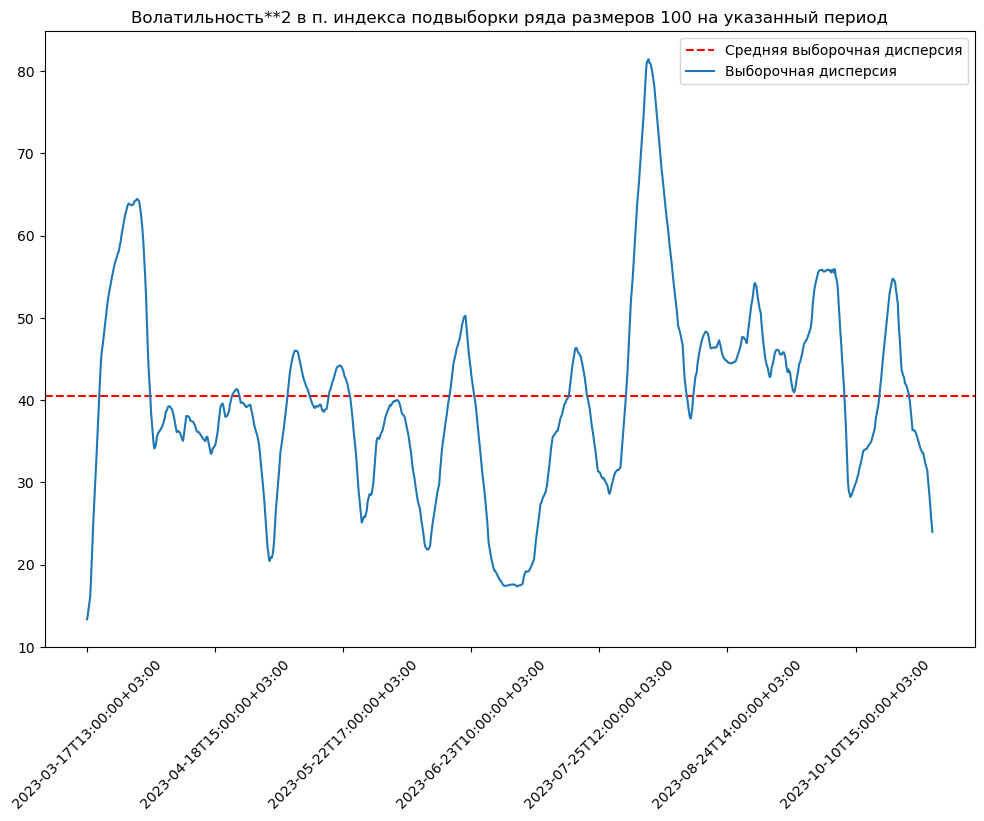

In [72]:
plt.figure(figsize = (12,8))
plt.title('Волатильность**2 в п. индекса подвыборки ряда размеров 100 на указанный период')
plt.axhline(np.mean(sigma_sample_100.values), linestyle = '--', color = 'red', label = 'Средняя выборочная дисперсия')
sigma_sample_100.plot(label = 'Выборочная дисперсия')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

Как видно, средняя выборочная дисперсия даже на таких промежутках времени сильно отличается,и включает в себя кластеры высокой/низкой волатильности, а также резкие периоды роста/падения данного показателя.

**Нагенерируем теперь** некоторые другие фичи и посмотрим на их статистики. Каждая из них будет отвечать на некоторых несложный интуитивных вопрос? 

### В скольки из n (n=100), включая само наблюдение, предшествующих периодов цена была выше/ниже текущей? 


In [77]:
up_before_array = []
down_before_array = []
up_mean_array = []
down_mean_array = []
up_down_before_index_array =[]
n = 100
# counter = 0
for ind, i in enumerate(df_60_additional_features['close'].rolling(n)):
    if ind <= 99:
        pass
    else:
        last_ind = i.index[-1]
        up_down_before_index_array.append(last_ind)
        cur_close = i[-1]
        
        mean_val = np.mean(i)
        
        down_count = 0
        up_count = 0 
        
        down_count_mean = 0
        up_count = 0 
#         print(i)
        for prev_close in i:
            if prev_close < cur_close:
                down_count += 1
            if prev_close < mean_val:
                down_count_mean += 1
                
        
        down_before_array.append(down_count)   
        up_before_array.append(n-down_count)   
        
        down_mean_array.append(down_count_mean)
        up_mean_array.append(n-down_count_mean)
        
#     counter += 1

In [79]:
up_count_sample_100 = pd.Series(up_before_array, index = up_down_before_index_array)

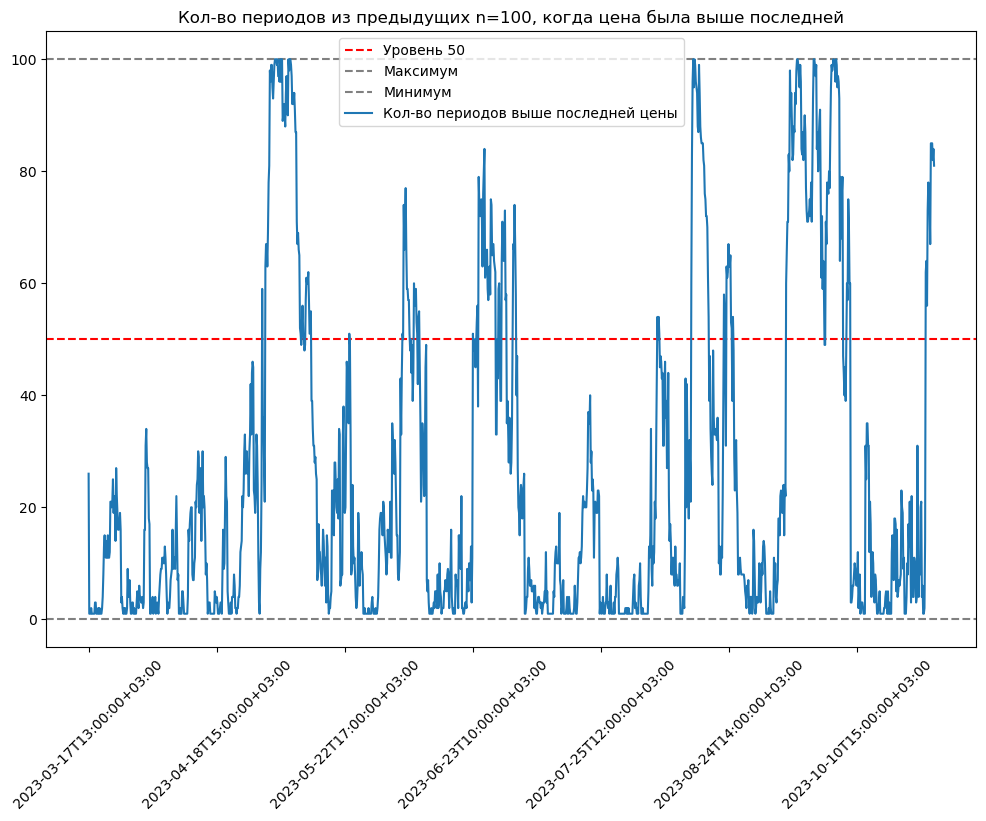

In [88]:
plt.figure(figsize = (12,8))
plt.title('Кол-во периодов из предыдущих n=100, когда цена была выше последней')
plt.axhline(50, linestyle = '--', color = 'red', label = 'Уровень 50')
plt.axhline(100, linestyle = '--', color = 'grey', label = 'Максимум')
plt.axhline(0, linestyle = '--', color = 'grey', label = 'Минимум')
up_count_sample_100.plot(label = 'Кол-во периодов выше последней цены')

plt.xticks(rotation = 45)
plt.legend()
plt.show()

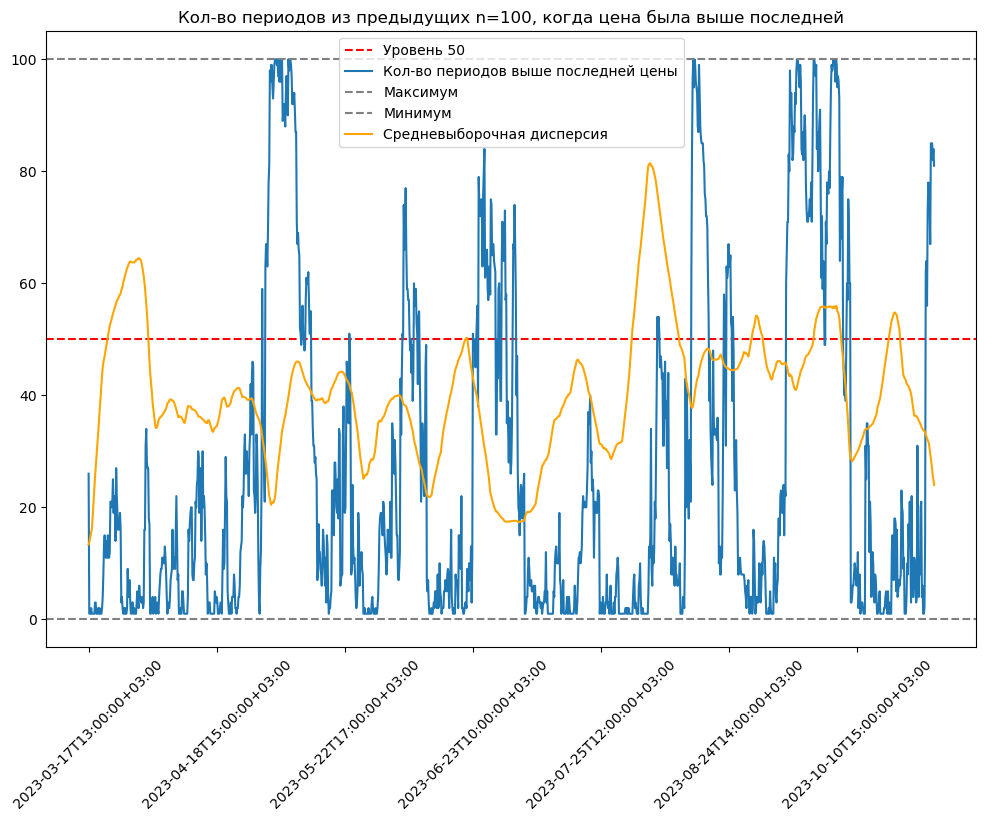

In [89]:
plt.figure(figsize = (12,8))
plt.title('Кол-во периодов из предыдущих n=100, когда цена была выше последней')
plt.axhline(50, linestyle = '--', color = 'red', label = 'Уровень 50')
up_count_sample_100.plot(label = 'Кол-во периодов выше последней цены')
plt.axhline(100, linestyle = '--', color = 'grey', label = 'Максимум')
plt.axhline(0, linestyle = '--', color = 'grey', label = 'Минимум')
sigma_sample_100.plot(label = 'Средневыборочная дисперсия', color = 'orange')
plt.xticks(rotation = 45)
plt.legend()
plt.show()



**Заметим**, что резкие изменения волатильности приходятся в основном на падения цены т.е. для восходящих тенденций характерна более низкая волатильность. Проверим что это так:

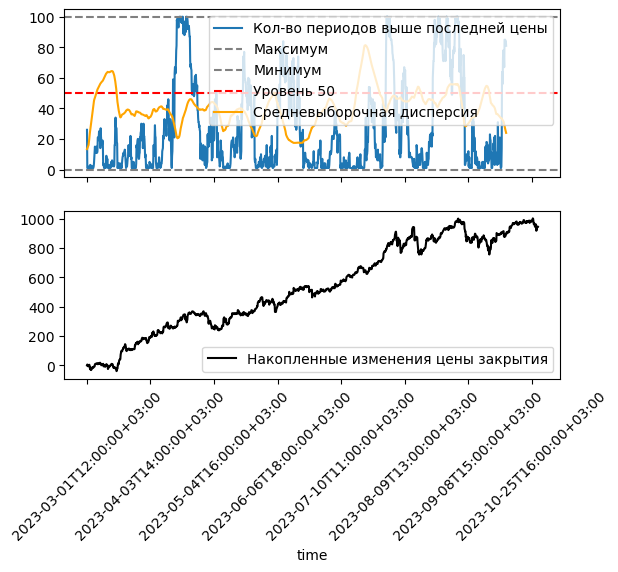

In [110]:
fig, ax = plt.subplots(nrows=2, ncols=1,sharex=True)
up_count_sample_100.plot(label = 'Кол-во периодов выше последней цены',ax = ax[0])
ax[0].axhline(100, linestyle = '--', color = 'grey', label = 'Максимум')
ax[0].axhline(0, linestyle = '--', color = 'grey', label = 'Минимум')
ax[0].axhline(50, linestyle = '--', color = 'red', label = 'Уровень 50')
sigma_sample_100.plot(label = 'Средневыборочная дисперсия', color = 'orange', ax = ax[0])

(df_60_additional_features['close']-df_60_additional_features['close'][0]).plot(color = 'black', label = 'Накопленные изменения цены закрытия', ax = ax[1])
# sigma_sample_100.plot(label = 'Средневыборочная дисперсия', color = 'orange', ax = ax[1])
plt.xticks(rotation = 45)
ax[0].legend()
ax[1].legend()
plt.show()

**На таком графике тенденция не очень видна, стоит его увеличить**

### В скольки из n-1 (n=100) предшествующих периодов цена была выше/ниже текущей средневыборочной? 

In [81]:
up_count_sample_mean_100 = pd.Series(up_mean_array, index = up_down_before_index_array)

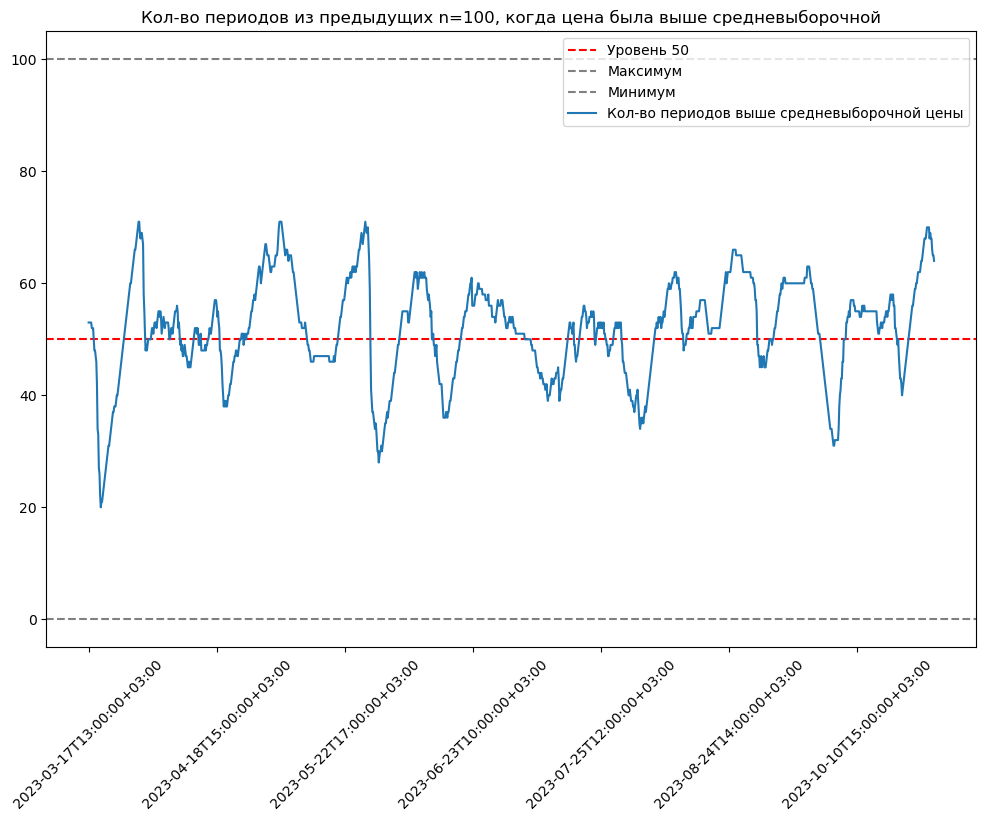

In [90]:
plt.figure(figsize = (12,8))
plt.title('Кол-во периодов из предыдущих n=100, когда цена была выше средневыборочной')
plt.axhline(50, linestyle = '--', color = 'red', label = 'Уровень 50')
plt.axhline(100, linestyle = '--', color = 'grey', label = 'Максимум')
plt.axhline(0, linestyle = '--', color = 'grey', label = 'Минимум')
up_count_sample_mean_100.plot(label = 'Кол-во периодов выше средневыборочной цены')

plt.xticks(rotation = 45)
plt.legend()
plt.show()

### Наложим на график изменения волатильности: 

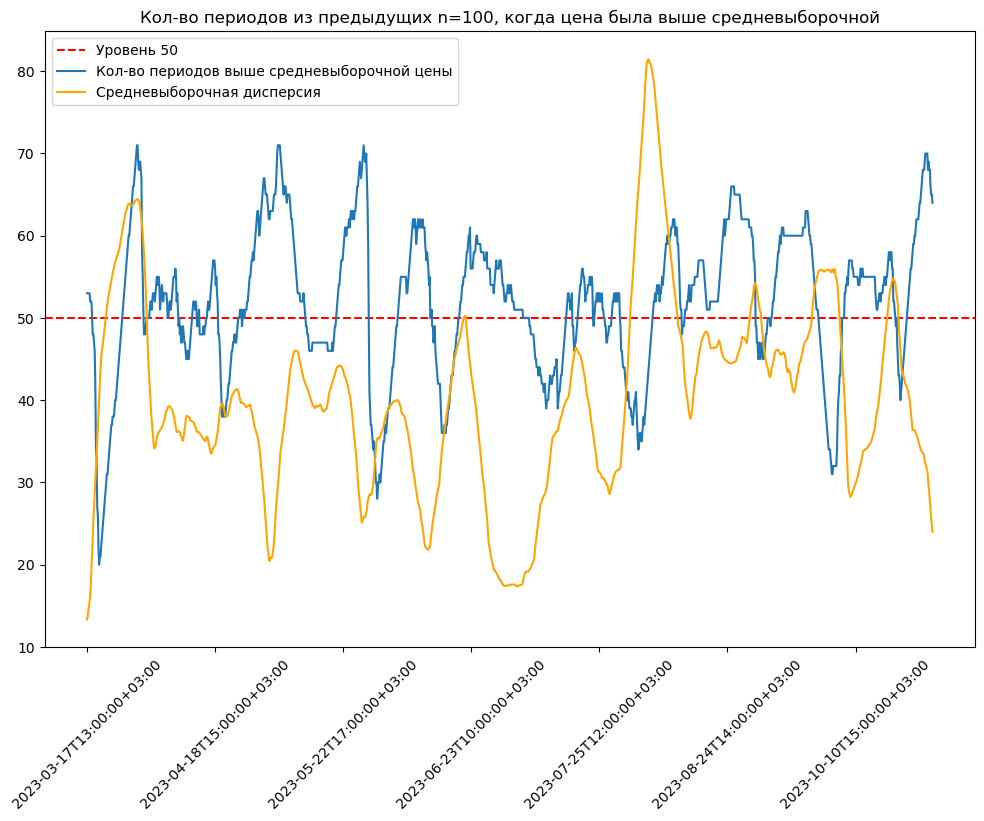

In [83]:
plt.figure(figsize = (12,8))
plt.title('Кол-во периодов из предыдущих n=100, когда цена была выше средневыборочной')
plt.axhline(50, linestyle = '--', color = 'red', label = 'Уровень 50')
up_count_sample_mean_100.plot(label = 'Кол-во периодов выше средневыборочной цены')
sigma_sample_100.plot(label = 'Средневыборочная дисперсия', color = 'orange')
plt.xticks(rotation = 45)
plt.legend()
plt.show()

**Заметим, что пики тенденций в целом совпадают**. Совпадут ли они с ценовыми пиками?

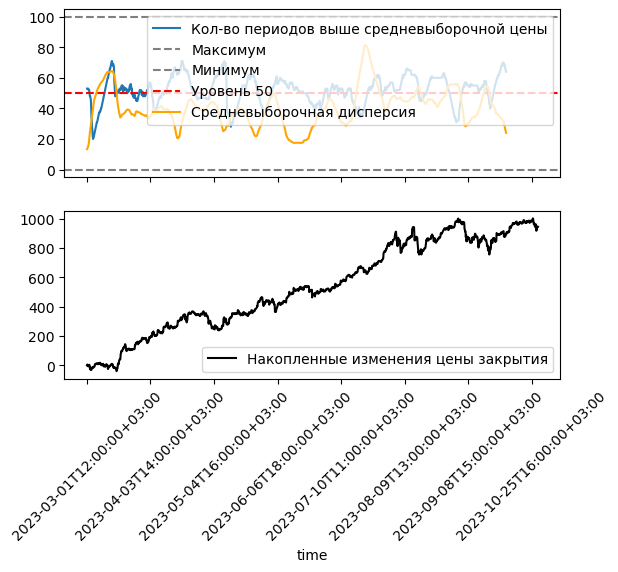

In [113]:
fig, ax = plt.subplots(nrows=2, ncols=1,sharex=True)
up_count_sample_mean_100.plot(label = 'Кол-во периодов выше средневыборочной цены',ax = ax[0])
ax[0].axhline(100, linestyle = '--', color = 'grey', label = 'Максимум')
ax[0].axhline(0, linestyle = '--', color = 'grey', label = 'Минимум')
ax[0].axhline(50, linestyle = '--', color = 'red', label = 'Уровень 50')
sigma_sample_100.plot(label = 'Средневыборочная дисперсия', color = 'orange', ax = ax[0])

(df_60_additional_features['close']-df_60_additional_features['close'][0]).plot(color = 'black', label = 'Накопленные изменения цены закрытия', ax = ax[1])
# sigma_sample_100.plot(label = 'Средневыборочная дисперсия', color = 'orange', ax = ax[1])
plt.xticks(rotation = 45)
ax[0].legend()
ax[1].legend()
plt.show()

**Опять-таки**, требуется посмотреть на график с увеличением

### Проверим "Купи и держи". В скольких случаях удержание в течение m периодов (m = {5,10,25,100,500}) было прибыльным для всего заданного ряда?

In [114]:
buy_and_hold_periods = [5,10,25,100,500]
max_buy_and_hold = max(buy_and_hold_periods)
all_closes = df_60_additional_features['close'].values
close_array = df_60_additional_features['close'].values[max_buy_and_hold-1:]
close_array_ind = df_60_additional_features['close'].index[max_buy_and_hold-1:]
len_array = len(close_array)

profitability_dict = {i : [] for i in buy_and_hold_periods}
# counter = 0
for ind, i in enumerate(close_array):
    for period in buy_and_hold_periods:
        if all_closes[ind+max_buy_and_hold-period] < i:
            profitability_dict[period].append(1)
        else:
            profitability_dict[period].append(0)

In [115]:
df_profitability = pd.DataFrame(profitability_dict,index = close_array_ind)

In [116]:
df_profitability.head()

,5,10,25,100,500
time,,,,,
2023-05-22T16:00:00+03:00,0,1,0,1,1
2023-05-22T17:00:00+03:00,0,1,0,1,1
2023-05-22T18:00:00+03:00,1,1,0,1,1
2023-05-23T10:00:00+03:00,1,0,0,1,1
2023-05-23T11:00:00+03:00,0,0,0,1,1


In [118]:
df_profitability.sum()/len_array

5      0.616052
10     0.652928
25     0.708243
100    0.843818
500    1.000000
dtype: float64

**Заметим, что для данной выборки** Buy and Hold почти всегда оказывался выигрышной стратегией. По-видимости, все это время цена находилась в восходящем тренде

### А как менялся резулььтат такой стратегии относительно базы (всех наблюдений, 1)?

In [127]:
from tqdm.auto import tqdm

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

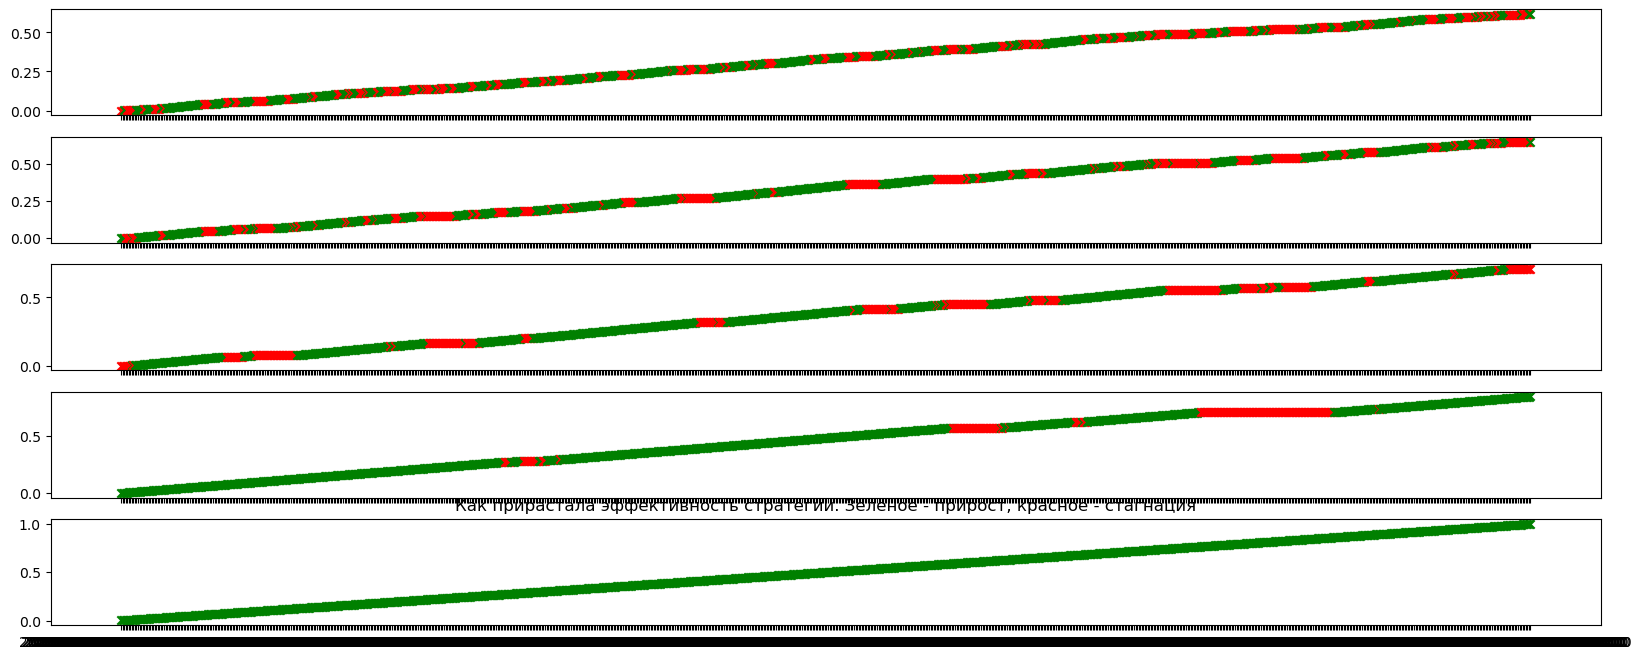

In [131]:
fig, ax = plt.subplots(nrows = len(buy_and_hold_periods), ncols = 1,figsize = (20,8), sharex = True)
plt.title('Как прирастала эффективность стратегии. Зеленое - прирост, красное - стагнация')
for col_no, period in enumerate(buy_and_hold_periods):
    for i,j,ind in tqdm(zip(df_profitability.cumsum()[period].values,df_profitability[period].values, df_profitability.index)):
        if j == 0:
            ax[col_no].scatter(ind,i/len_array, color = 'red', marker = 'x')
        else:
            ax[col_no].scatter(ind,i/len_array, color = 'green', marker = 'x')
            
    
plt.show()

In [130]:
for col_no, period in enumerate(buy_and_hold_periods):
    print(col_no, period)

0 5
1 10
2 25
3 100
4 500


<!-- **Поделим всю выборку на децили. Посмотрим, сколько времени цена находилась в каждом из децилей?** -->

## Заготовка под анализ кросс-корреляций и похожести скользящих окон между собой - подход к сравнению: различные модификации DTW 

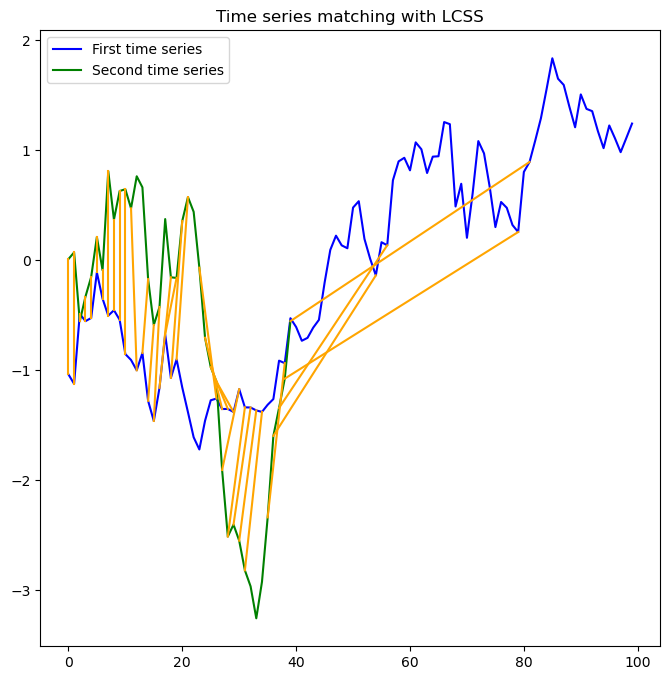

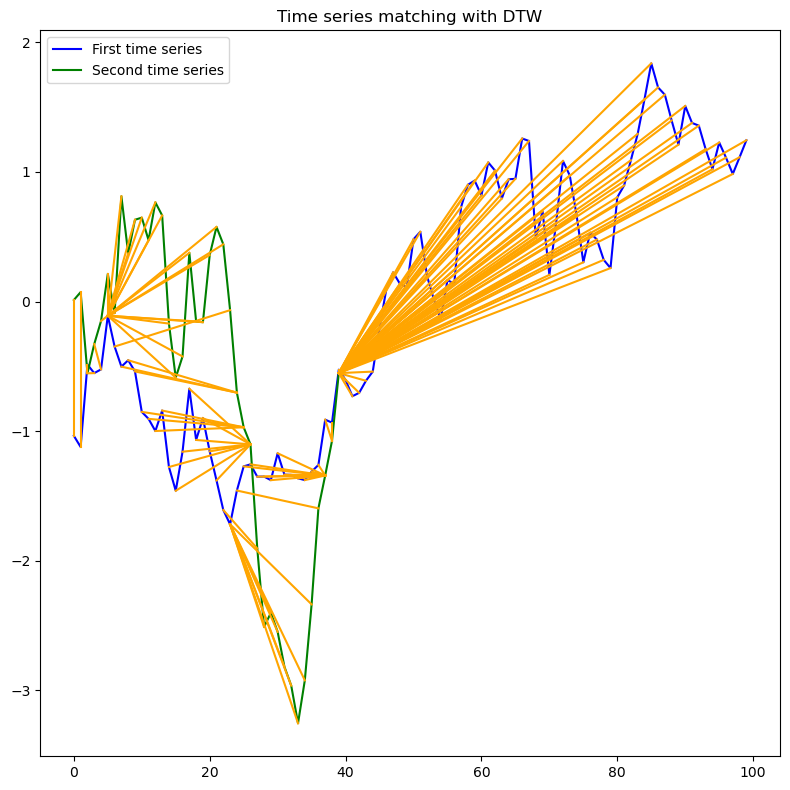

In [1]:
import numpy
import matplotlib.pyplot as plt

from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn import metrics


numpy.random.seed(0)
n_ts, sz, d = 2, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d, random_state=5)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset_scaled = scaler.fit_transform(dataset)

lcss_path, sim_lcss = metrics.lcss_path(dataset_scaled[0, :, 0], dataset_scaled[1, :40, 0], eps=1.5)
dtw_path, sim_dtw = metrics.dtw_path(dataset_scaled[0, :, 0], dataset_scaled[1, :40, 0])

plt.figure(1, figsize=(8, 8))

plt.plot(dataset_scaled[0, :, 0], "b-", label='First time series')
plt.plot(dataset_scaled[1, :40, 0], "g-", label='Second time series')

for positions in lcss_path:
    plt.plot([positions[0], positions[1]],
             [dataset_scaled[0, positions[0], 0], dataset_scaled[1, positions[1], 0]], color='orange')
plt.legend()
plt.title("Time series matching with LCSS")

plt.figure(2, figsize=(8, 8))
plt.plot(dataset_scaled[0, :, 0], "b-", label='First time series')
plt.plot(dataset_scaled[1, :40, 0], "g-", label='Second time series')

for positions in dtw_path:
    plt.plot([positions[0], positions[1]],
             [dataset_scaled[0, positions[0], 0], dataset_scaled[1, positions[1], 0]], color='orange')

plt.legend()
plt.title("Time series matching with DTW")

plt.tight_layout()
plt.show()

In [2]:
from tslearn.metrics import dtw, dtw_path

dtw_score = dtw(x, y)
# Or, if the path is also an important information:
optimal_path, dtw_score = dtw_path(x, y)

NameError: name 'x' is not defined